In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 43.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 184kB 11.0MB/s 
     |████████████████████████████████| 15.2MB 2.7MB/s 
     |████████████████████████████████| 10.6MB 66.8MB/s 
     |████████████████████████████████| 14.5MB 3.1MB/s 
     |████████████████████████████████| 235kB 15.8MB/s 
     |████████████████████████████████| 2.2MB 11.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=10c15da61c61b1950ad441cbc396b46fe21e2618cbcb22e4e2fedc90a3ad8cc9
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Successfully built torch-geometric


In [ ]:
import torch; print(torch.__version__)

1.4.0


In [ ]:
 !python -c "import torch; print(torch.__version__)"

1.4.0


In [ ]:
!python -c "import torch; print(torch.version.cuda)"

10.1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from torchvision.datasets import MNIST
import multiprocessing

import numpy as np
import scipy as sp
from skimage.segmentation import slic, mark_boundaries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
import torch
import networkx as nx

%matplotlib inline

In [ ]:
#A = torch.tensor( nx.adjacency_matrix(G).todense(), dtype=torch.float32 )### graph to adjacency conversion



In [ ]:
class CNNfeaturemap(torch.nn.Module):
  def __init__(self):
        super(CNNfeaturemap, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3, stride=2,padding=1)
        
        self.conv6 = nn.Conv2d(128, 256, 3, stride=2,padding=1)
        self.conv7 = nn.Conv2d(256, 1024, 3, stride=1,padding=1)
        
        #self.layernorm=nn.LayerNorm([14, 14])
        #self.layernorm1=nn.LayerNorm([7, 7])
        #self.layernorm2=nn.LayerNorm([7, 7])

  def forward(self, x):
        #print(torch.max(x))
        x1 = F.leaky_relu(self.conv1(x),0.2)#F.relu(self.conv1(x))
        #x1=self.layernorm(x1)
        
        x6 = F.leaky_relu(self.conv6(x1),0.2)#F.relu(self.conv6(x1))
        #x6=self.layernorm1(x6)
        x7 = F.leaky_relu(self.conv7(x6),0.2)
        #x7=self.layernorm2(x7)

        #print('torch_max',torch.max(x7))
               
        return x7




class Encoder(torch.nn.Module):                        ######### aim is to create feature vector for GNN
  def __init__(self):                                  ###### Basic AE advanced VAE
        super(Encoder, self).__init__()                ###### Adaptive average pooling  and then flattened vector should be the output
        self.conv1 = nn.Conv2d(1024, 512, 3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(512, 128, 3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(128, 6, 3, stride=1,padding=1)
        self.conv6 = nn.Conv2d(6, 6, 3, stride=1,padding=1)
        self.conv7 = nn.Conv2d(6, 6, 1, stride=1)
  def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
  def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
  def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
        

  def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x),0.2)
        #print(x1.size())
        x2 = F.leaky_relu(self.conv2(x1),0.2)
        
        x5 = F.leaky_relu(self.conv5(x2),0.2)
        #print(torch.max(x5))
        x6=torch.nn.AdaptiveAvgPool2d(7)(x5)
        
        feat=torch.nn.Flatten()(x6)
        mu = torch.nn.Flatten()(self.conv6(x6))
        logvar = torch.nn.Flatten()(self.conv7(x6))
        z=self.reparameterize(mu, logvar)

        return z,feat,mu,logvar

class Decoder(torch.nn.Module):            ######### aim is to create Adjacency matrix and Feature vector
  def __init__(self ):                     ###### inner product is adjacency matrix
        super(Decoder, self).__init__()   

  def gamma(A):
    gam=1+49/(torch.sum(A)+10e-7)    
    gam=gam.pow(0.5)    
    A1=A+gam*torch.diag(A)        
    return gam,A1
  
  def forward(self, x):
        A=x@x.t()
        gam=1+49/(torch.sum(A)+10e-7)    #################
        gam=gam.pow(0.5)                  ###########         Creating adaptive factor gamma
        A1=A+gam*torch.diag(A)           #########adding adaptive enhancement to adjacency matrix

        return gam,A1,x
#p=torch.zeros((1,1024,7,7))
#a,b,c,d=Encoder()(p)
#print(a.size())
#a,b,c,d=Encoder()(p)
#print(ad.size(),xt.size())



class GINConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = torch.nn.Linear(6, 6)
        self.linear1=torch.nn.Linear(6, 6)

    def forward(self, A, X):
        """
        Params
        ------
        A [batch x nodes x nodes]: adjacency matrix
        X [batch x nodes x features]: node features matrix
        
        Returns
        -------
        X' [batch x nodes x features]: updated node features matrix
        """
        X = self.linear(X + A @ X )#+ A**2 @ X)
        X1 = F.leaky_relu(X,0.2)
        X2=self.linear1(X1 + A @ X1)
        gam=1+49/(torch.sum(A)+10e-7)    #################
        gam=gam.pow(0.5) 
        z_sum_opt=gam*X1+X2
        
        return z_sum_opt




In [ ]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    #min_val = np.min(x)
    max_val = np.max(x)
    x = x / max_val
    return x
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)
def kld_loss(mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD
def kdl_loss(gamm,A):
  kdl1=-gamm/49*49
  kdl=kdl1*torch.sum(torch.log(torch.clamp(A, min=0, max=1)+10e-7))
  return kdl




class SCG(torch.nn.Module):
    def __init__(self):
        super(SCG, self).__init__()
        self.cnnfeaturemap=CNNfeaturemap()
        self.encoder=Encoder()
        self.decoder=Decoder()
        self.gin=GINConv()
        self.conv1=nn.Conv2d(6, 6, 3, stride=1,padding=1)
        self.upsample1=torch.nn.Upsample(scale_factor=4, mode='nearest')
        self.conv2=nn.Conv2d(6, 6, 3, stride=1,padding=1)
        #self.layernorm=nn.LayerNorm([28, 28])
        self.conv3=nn.Conv2d(6, 1, 3, stride=1,padding=1)
        #self.layernorm1=nn.LayerNorm([28, 28])

        

    def forward(self, x):
        cnf=self.cnnfeaturemap(x)
        #print('cnf',cnf.size())
        z,feat,mu,logvar=self.encoder(cnf)
        #enc1=enc.squeeze()
        #print(z.size())
        z=torch.reshape(z,(49,6))
        gam,adj,featurematrix=self.decoder(z)
        #print(adj.size(),featurematrix.size())
        fmatrix=self.gin(adj,featurematrix)
        
        
        fmatrix=torch.reshape(fmatrix,(1,6,7,7))
        fmatrix=self.conv1(fmatrix)
        fmatrix1=F.leaky_relu(fmatrix,0.2)
        z1=mu*(1-logvar)                                                ########### residual term as per paper
        z1=z1*gam                                                       ########## adaptive enhancement gam is added to residual z1
        fmatrix1=nn.Flatten()(fmatrix1)
        #zf=z1+fmatrix1
        zf=fmatrix1
        zf=torch.reshape(zf,(1,6,7,7))
        zf=self.upsample1(zf)
        fmatrix2=self.conv2(zf)
        fmatrix2=F.leaky_relu(fmatrix2,0.2)
        
        #fmatrix2=self.layernorm(fmatrix2)
        fmatrix2=self.conv3(fmatrix2)
        fmatrix2=torch.reshape(fmatrix2,(1,1,28,28))
        
        #fmatrix2=nn.LogSoftmax(dim=1)(fmatrix2)
        #fmatrix2=self.layernorm1(fmatrix2)
        fmatrix2=F.sigmoid(fmatrix2)
        #fmatrix2=nn.Softmax(dim=1)(fmatrix2)

        return fmatrix2,mu,logvar,gam,adj,x,cnf,z,feat

####################     Data precessing mnist##############
dset_folder = "./mnist"
channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())


print("Reading dataset")
dset = MNIST(dset_folder,download=True)
def normalise_dataset(data):
  return np.array([normalize(xi) for xi in data])
imgs = dset.data.unsqueeze(-1).numpy().astype(np.float64)
imgs=imgs[:5000,:,:,0]
imgs=normalise_dataset(imgs)
labels = dset.targets.numpy()




imgst = dset.data.unsqueeze(-1).numpy().astype(np.float64)
imgst=imgst[100:110,:,:,0]
tensor_x = torch.Tensor(imgs) # transform to torch tensor
tensor_y = torch.Tensor(imgs)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset,batch_size=1, shuffle=True) # create your dataloader

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)




model = SCG()
#model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)





##############train and test#############
#for epoch in range(1, 1000):
    
#    img,loss,x,out=train(epoch,imgs)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" )
for epoch in range(10):
    # Training
    for local_batch, local_labels in my_dataloader:
        # Transfer to GPU
        optimizer.zero_grad()
        local_batch, local_labels = local_batch, local_labels#local_batch.to(torch.device('cuda')), local_labels.to(torch.device('cuda'))#local_batch.cuda(), local_labels.cuda()#local_batch.to('cuda'), local_labels.to('cuda')
        #i,mu,logvar,gamm,adj = model(local_batch)
        #print(local_batch.size())
        local_batch=torch.reshape(local_batch,(local_batch.shape[0],1,local_batch.shape[1],local_batch.shape[2]))
        i,mu,logvar,gamm,adj,inp,cnf,z,feat = model(local_batch)
        #loss = torch.nn.functional.mse_loss(i,local_batch) + kld_loss(mu,logvar) #+ kdl_loss(gamm,adj)#dice_loss(i,img.float())#torch.nn.MSELoss()(i,img.float())
        
        loss=torch.nn.BCELoss()(i,local_batch)+kld_loss(mu,logvar)#+kdl_loss(gamm,adj)
        #loss=dice_loss(i,local_batch+kld_loss(mu,logvar))#+kdl_loss(gamm,adj)
        loss.backward()
        optimizer.step()

    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch,loss))
    

CUDA availability: True
Reading dataset


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 000, Loss: 2.6879
Epoch: 001, Loss: 3.7978
Epoch: 002, Loss: 3.2876
Epoch: 003, Loss: 2.6438
Epoch: 004, Loss: 4.3664
Epoch: 005, Loss: 4.7159
Epoch: 006, Loss: 4.5815
Epoch: 007, Loss: 7.0506
Epoch: 008, Loss: 2.4296
Epoch: 009, Loss: 2.6343


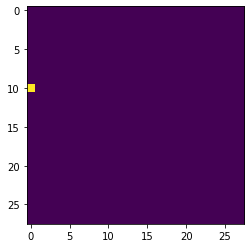

In [ ]:
plt.imshow(np.squeeze(i.detach().numpy()))

In [ ]:
#cnf
#plt.imshow(np.squeeze(cnf.detach().numpy()))#############size:1024x7x7
print(torch.max(cnf))
print(torch.min(cnf))

tensor(0.4356, grad_fn=<MaxBackward1>)
tensor(-0.0909, grad_fn=<MinBackward1>)


tensor(2.9357, grad_fn=<MaxBackward1>)
tensor(-1.9642, grad_fn=<MinBackward1>)


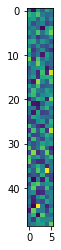

In [ ]:
#z
plt.imshow(np.squeeze(z.detach().numpy()))
print(torch.max(z))
print(torch.min(z))

In [ ]:
#feat
#plt.imshow(np.squeeze(feat.detach().numpy()))
print(torch.max(feat))
print(torch.min(feat))

tensor(0.5093, grad_fn=<MaxBackward1>)
tensor(-0.1644, grad_fn=<MinBackward1>)


number of edges 1225
number of nodes 49


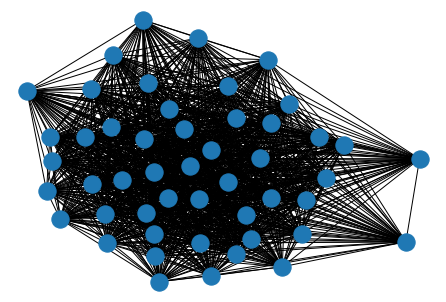

In [ ]:
#adj=adj.detach().numpy()
#adj=nx.from_numpy_matrix(adj)

H=nx.Graph(adj) 
print('number of edges',H.number_of_edges())
print('number of nodes',H.number_of_nodes())

nx.draw(H)
plt.show()

In [ ]:

out=i.cpu().detach().numpy()
print(np.max(out))
print(np.min(out))

1.7924854e-37
0.0


1.0


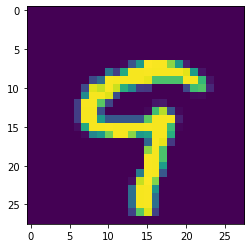

In [ ]:
plt.imshow(np.squeeze(inp.detach().numpy()))
print(np.max(inp.numpy()))

In [ ]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(output.shape)

torch.Size([2, 3])
